In [1]:
import einops
import tensorflow as tf
from tensorflow import keras
from keras import layers as L
from keras import models as M
from keras import losses as LL
from keras import callbacks as C
import pandas as pd
import pathlib
import numpy as np
from tensorflow_text import normalize_utf8
from matplotlib import pyplot as plt

2023-01-06 02:58:07.319648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-06 02:58:07.498932: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-06 02:58:07.498958: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-06 02:58:08.451078: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Load dataset

In [2]:
path_to_file = pathlib.Path().home() / "tensorflow_datasets" / "anki" / "ita-eng" / "ita.txt"
df = pd.read_csv(path_to_file, sep="\t", header=None)
df.columns=["eng", "ita", "author"]
df["split"] = np.where(np.random.uniform(size=(len(df),)) < 0.8, "train", "val")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358373 entries, 0 to 358372
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   eng     358373 non-null  object
 1   ita     358373 non-null  object
 2   author  358373 non-null  object
 3   split   358373 non-null  object
dtypes: object(4)
memory usage: 10.9+ MB


In [3]:
df.head()

,eng,ita,author,split
0,Hi.,Ciao!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...,train
1,Hi.,Ciao.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...,train
2,Run!,Corri!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...,train
3,Run!,Corra!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...,train
4,Run!,Correte!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...,train


## Prep dataset

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
VOCAB_SIZE = 30000

In [5]:
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((
        df.query("split == 'train'")["ita"].values,
        df.query("split == 'train'")["eng"].values,
    ))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

val_raw = (
    tf.data.Dataset
    .from_tensor_slices((
        df.query("split == 'val'")["ita"].values,
        df.query("split == 'val'")["eng"].values,
    ))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

2023-01-06 02:58:11.848082: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-06 02:58:11.848115: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-06 02:58:11.848148: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (calcifer-Inspiron-7370): /proc/driver/nvidia/version does not exist
2023-01-06 02:58:11.848444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
@tf.function
def clean_string(s):
    # Split accented characters
    text = normalize_utf8(s, "NFKD")
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,;]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,;]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)
    # Add START and END tokens
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [7]:
vectorizer_src = L.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=clean_string,
    ragged=True,
    encoding='utf-8',
)
vectorizer_src.adapt(train_raw.map(lambda src, dst: src))

vectorizer_dst = L.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=clean_string,
    ragged=True,
    encoding='utf-8',
)

vectorizer_dst.adapt(train_raw.map(lambda src, dst: dst))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
def prep_dataset(src, dst):
    src_enc = vectorizer_src(src).to_tensor()
    dst_enc = vectorizer_dst(dst)
    dst_in = dst_enc[:, :-1].to_tensor()
    dst_out = dst_enc[:, 1:].to_tensor()
    return (src_enc, dst_in), dst_out

In [9]:
ds_train = train_raw.map(prep_dataset, tf.data.AUTOTUNE)
ds_val = val_raw.map(prep_dataset, tf.data.AUTOTUNE)

## Model development

In [17]:
EMBEDDING_DIM = 128
RNN_UNITS = 128
ATTENTION_UNITS = 16

In [11]:
rnn_kwargs = dict(
    dropout=0.2, 
    recurrent_dropout=0.2, 
    recurrent_initializer="glorot_uniform",
)

In [12]:
class ShapeChecker():
    def __init__(self):
    # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        parsed = einops.parse_shape(tensor, names)

        for name, new_dim in parsed.items():
            old_dim = self.shapes.get(name, None)

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"    found: {new_dim}\n"
                                 f"    expected: {old_dim}\n")

In [13]:
class Encoder(M.Model):
    
    def __init__(self, rnn_units: int, vocab_size: int, embedding_dim: int):
        super(Encoder, self).__init__()
        self.embedding = L.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)
        self.rnn = L.Bidirectional(
            layer=L.GRU(units=rnn_units, return_sequences=True, **rnn_kwargs),
            merge_mode="sum",
        )

    def call(self, inputs):
        x = self.embedding(inputs)
        outputs = self.rnn(x)
        return outputs

In [14]:
class AdditiveAttention(L.Layer):
    
    def __init__(self, units: int):
        super().__init__()
        self.w1 = L.Dense(units=units, use_bias=False)
        self.w2 = L.Dense(units=units, use_bias=False)
        self.v = L.Dense(1, use_bias=False)

    def call(self, query, keys):
        shape_checker = ShapeChecker()
        shape_checker(query, "batch t_enc rnn_units")
        shape_checker(keys, "batch t_dec emb_dec")
        # add nexaxis for broadcasting addition along the time dimensions
        scores_query = tf.expand_dims(self.w1(query), axis=2)
        scores_keys = tf.expand_dims(self.w2(keys), axis=1)
        scores = self.v(tf.tanh(tf.add(scores_query, scores_keys)))
        scores = tf.squeeze(scores, axis=-1)
        shape_checker(scores, "batch t_enc t_dec")
        attention_scores = tf.math.softmax(scores, axis=-1)  # for each t_enc, unit sum
        context = tf.matmul(attention_scores, keys)
        return context, attention_scores

In [15]:
class Decoder(M.Model):

    def __init__(self, rnn_units: int, vocab_size: int, embedding_dim: int, attention_units: int):
        super(Decoder, self).__init__()
        self.embedding = L.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)
        self.rnn = L.GRU(units=rnn_units, return_state=True, return_sequences=True, **rnn_kwargs)
        self.attention = AdditiveAttention(units=attention_units)
        self.out = L.Dense(units=vocab_size)
        self.last_attention_scores = None
    
    def call(self, inputs, enc_hidden_states, state=None, return_state=False):
        shape_checker = ShapeChecker()
        shape_checker(inputs, "batch t_dec")
        shape_checker(enc_hidden_states, "batch t_enc rnn_units")
        #
        emb = self.embedding(inputs)
        shape_checker(emb, "batch t_dec emb")
        #
        rnn_out, rnn_state = self.rnn(emb, initial_state=state)
        shape_checker(rnn_out, "batch t_dec rnn_units")
        #
        context, attention_scores = self.attention(rnn_out, enc_hidden_states)
        self.last_attention_scores = attention_scores
        shape_checker(context, "batch t_dec rnn_units")
        logits = self.out(context)
        shape_checker(logits, 'batch t_dec vocab_size')
        if return_state:
            return logits, state
        else:
            return logits

In [16]:
shape_checker = ShapeChecker()
(enc_inputs, dec_inputs), dec_outputs = ds_train.take(1).as_numpy_iterator().next()
shape_checker(enc_inputs, "batch t_enc")

encoder = Encoder(rnn_units=RNN_UNITS, embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE)
enc_outputs = encoder(enc_inputs)
shape_checker(enc_outputs, "batch t_enc rnn_units")

decoder = Decoder(rnn_units=RNN_UNITS, embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE, attention_units=16)
logits = decoder(dec_inputs, enc_outputs)

logits.shape

TensorShape([64, 6, 30000])

In [18]:
class Translator(M.Model):
    def __init__(
        self, 
        rnn_units: int = RNN_UNITS, 
        vocab_size: int = VOCAB_SIZE, 
        embedding_dim: int = EMBEDDING_DIM, 
        attention_units: int = ATTENTION_UNITS,
    ):
        super(Translator, self).__init__()
        self.encoder = Encoder(rnn_units=rnn_units, embedding_dim=embedding_dim, vocab_size=vectorizer_src.vocabulary_size())
        self.decoder = Decoder(rnn_units=rnn_units, embedding_dim=embedding_dim, vocab_size=vectorizer_dst.vocabulary_size(), attention_units=attention_units)
    
    def call(self, inputs):
        inputs_enc, inputs_dec = inputs
        enc_hidden_states = self.encoder(inputs_enc)
        logits = self.decoder(inputs_dec, enc_hidden_states)
        try:
            # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass
        return logits


translator = Translator()

translator((enc_inputs, dec_inputs))
translator.summary(expand_nested=True)

Model: "translator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3584640   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| embedding_2 (Embedding)   multiple                  3386496   |
|                                                               |
| bidirectional_1 (Bidirectio  multiple               198144    |
| nal)                                                          |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 decoder_1 (Decoder)         multiple                  3504579   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| embedding_3 (Embedding)   multiple                  1694080   |
|                                                               |
| gru_3 (GRU)               multiple                  99072     |
|                                                       

In [24]:
inputs_enc = L.Input(shape=(None,))
inputs_dec = L.Input(shape=(None,))
encoder = Encoder(rnn_units=RNN_UNITS, embedding_dim=EMBEDDING_DIM, vocab_size=vectorizer_src.vocabulary_size())
decoder = Decoder(rnn_units=RNN_UNITS, embedding_dim=EMBEDDING_DIM, vocab_size=vectorizer_dst.vocabulary_size(), attention_units=ATTENTION_UNITS)
enc_hidden_states = encoder(inputs_enc)
logits = decoder(inputs_dec, enc_hidden_states)
translator = M.Model(inputs=(inputs_enc, inputs_dec), outputs=logits)

translator.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 encoder_2 (Encoder)            (None, None, 128)    3584640     ['input_1[0][0]']                
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| embedding_4 (Embedding)      multiple             3386496     []                               |
|                                                                                             

## Model setup

In [25]:
def masked_loss(y_true, y_pred):
    loss_fn = LL.SparseCategoricalCrossentropy(from_logits=True, reduction="none")
    loss = loss_fn(y_true, y_pred)
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask
    avg_loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return avg_loss

In [26]:
def masked_accuracy(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    accuracy = tf.reduce_sum(match) / tf.reduce_sum(mask)
    return accuracy

In [27]:
vocab_size = float(vectorizer_dst.vocabulary_size())
expected_loss = tf.math.log(vocab_size).numpy()
expected_accuracy = 1.0 / vocab_size
print(f"{expected_loss=}, {expected_accuracy=}")

expected_loss=9.49062, expected_accuracy=7.555723460521345e-05


In [28]:
translator.compile(
    optimizer="adam",
    loss=masked_loss,
    metrics=[masked_accuracy, masked_loss],
)

In [30]:
translator.evaluate(ds_val, steps=100, return_dict=True)

100/100 [==============================] - 7s 69ms/step - loss: 9.4906 - masked_accuracy: 3.0769e-05 - masked_loss: 9.4906


{'loss': 9.490619659423828,
 'masked_accuracy': 3.076923167100176e-05,
 'masked_loss': 9.490619659423828}

## Training

In [31]:
EPOCHS = 100

In [32]:
history = translator.fit(
    ds_train.repeat(), 
    epochs=EPOCHS,
    steps_per_epoch=100,
    validation_data=ds_val,
    validation_steps=20,
    callbacks=[C.EarlyStopping(patience=3)],
)

Epoch 1/10
100/100 [==============================] - 22s 152ms/step - loss: 5.8087 - masked_accuracy: 0.2113 - masked_loss: 5.8087 - val_loss: 4.8915 - val_masked_accuracy: 0.1940 - val_masked_loss: 4.8915
Epoch 2/10
100/100 [==============================] - 15s 152ms/step - loss: 4.4878 - masked_accuracy: 0.2058 - masked_loss: 4.4878 - val_loss: 4.6562 - val_masked_accuracy: 0.1955 - val_masked_loss: 4.6562
Epoch 3/10
100/100 [==============================] - 16s 160ms/step - loss: 4.4606 - masked_accuracy: 0.2037 - masked_loss: 4.4606 - val_loss: 4.4094 - val_masked_accuracy: 0.2022 - val_masked_loss: 4.4094
Epoch 4/10
100/100 [==============================] - 18s 177ms/step - loss: 4.2833 - masked_accuracy: 0.2412 - masked_loss: 4.2833 - val_loss: 4.1898 - val_masked_accuracy: 0.2689 - val_masked_loss: 4.1898
Epoch 5/10
100/100 [==============================] - 18s 176ms/step - loss: 4.1362 - masked_accuracy: 0.2955 - masked_loss: 4.1362 - val_loss: 3.9774 - val_masked_accuracy

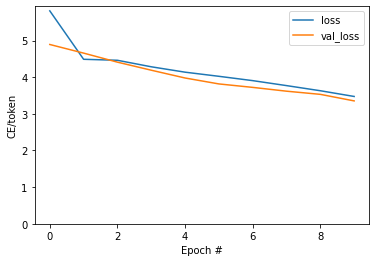

In [33]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

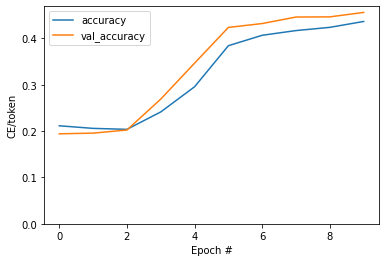

In [34]:
plt.plot(history.history['masked_accuracy'], label='accuracy')
plt.plot(history.history['val_masked_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
enc_inputs.shape

In [ ]:
enc_outputs.shape

In [ ]:
dec_inputs[:, :3].shape

In [ ]:
decoder_emb = decoder.embedding(dec_inputs[:, :3])
decoder_emb.shape

In [ ]:
dec_rnn_out, state = decoder.rnn(decoder_emb)
print(dec_rnn_out.shape)
print(state.shape)

In [ ]:
attention = AdditiveAttention(units=16)

In [ ]:
scores_keys = tf.expand_dims(attention.w1(enc_outputs), axis=1)
scores_keys.shape

In [ ]:
scores_values = tf.expand_dims(attention.w2(dec_rnn_out), axis=2)
scores_values.shape

In [ ]:
scores = attention.v(tf.tanh(tf.add(scores_keys, scores_values)))
scores = tf.squeeze(scores)  # drop last dimension
scores.shape

In [ ]:
attention_scores = tf.math.softmax(scores, axis=-1)
attention_scores.shape

In [ ]:
tf.matmul(attention_scores, enc_outputs).shape